# Applied Machine Learning 
# HW2 :Task 1

Maxime TCHIBOZO (mt3390)

Disclaimer : For a reason I have not been able to identify, the pipelines I created in this task tended to generate ConvergenceWarnings. I have opted to ignore these warnings as the results output by the functions were good.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import warnings

In [2]:
#collect the dataset
credit_g_dict = fetch_openml("credit-g")

# 1.1 Categorical Features vs. Continuous Features

In [4]:
print(credit_g_dict.feature_names)

['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']


In total, we have 20 features (excluding the target). Some of the categorical features are detailed by the "categories" key of the credit_g dictionary. Upon further analysis, we observe that there are additional categorical variables : installment_commitment, residence_since ,existing_credits ,num_dependents.

In [5]:
print("The Categorical Features are : "+str(list(credit_g_dict["categories"].keys())+["installment_commitment", "residence_since" ,"existing_credits" ,"num_dependents"]))

The Categorical Features are : ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']


We can consider that the following features are continuous : duration, credit_amount and age

## 1.2 Distributions of Continuous Features and Target

In [6]:
#create feature and target data frames
df_X = pd.DataFrame(credit_g_dict.data,columns=credit_g_dict.feature_names)
df_y = pd.DataFrame(credit_g_dict.target,columns=credit_g_dict.target_names)

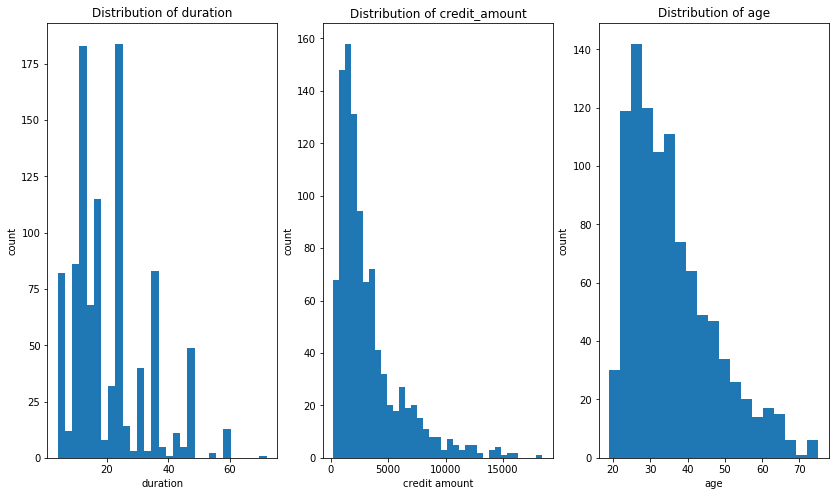

In [7]:
#distribution of the continuous variables    
fig, ax = plt.subplots(1,3,figsize=(14,8))

ax[0].hist(df_X["duration"],bins="auto",)
ax[1].hist(df_X["credit_amount"],bins="auto")
ax[2].hist(df_X["age"],bins="auto")

ax[0].set_xlabel("duration")
ax[1].set_xlabel("credit amount")
ax[2].set_xlabel("age")

ax[0].set_ylabel("count")
ax[1].set_ylabel("count")
ax[2].set_ylabel("count")

ax[0].title.set_text("Distribution of duration")
ax[1].title.set_text("Distribution of credit_amount")
ax[2].title.set_text("Distribution of age")

Text(0.5, 1.0, 'Distribution of the target')

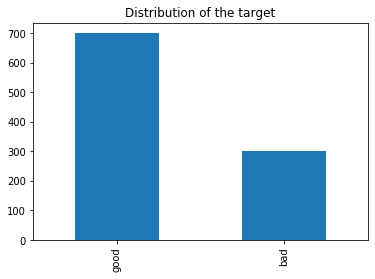

In [8]:
#distribution of the target
df_y['class'].value_counts().plot(kind='bar')
plt.title("Distribution of the target")

## 1.3 Preprocessing of the features

In [9]:
#We encode the target to 0-1 values
df_y["IsGood"] = df_y["class"].apply(lambda x: int(x=="good"))

#We convert the categorical variables to objects
#To do so we consider all columns other than age, duration and credit_amount
df = df_X[df_X.columns.difference(["age","duration","credit_amount"])].astype("object")

#We dummy encode the categorical variables and save them to df
df = pd.get_dummies(df)

#We scale the continuous variables and append them to df
scaler = StandardScaler()
scaler.fit(df_X[["age","duration","credit_amount"]])
df = pd.concat([df, pd.DataFrame(scaler.transform(df_X[["age","duration","credit_amount"]]),columns=["age","duration","credit_amount"])
], axis=1)

In [10]:
np.shape(df)

(1000, 71)

Scaling the continuous variables and encoding the categorical variables now means our preprocessed dataframe, df, has 71 features.

Let us note that we also encoded the values of the target to be 1 if the class is "good" and 0 otherwise (stored in df_y["IsGood"]).

In [11]:
#Initial Logistic Regression Model

X_train, X_test, y_train, y_test = train_test_split(df,df_y["IsGood"])

#We evaluate the model using a training/validation split
X_train_2, X_validate, y_train_2, y_validate = train_test_split(X_train,y_train)
model = LogisticRegression().fit(X_train_2,y_train_2)
model.score(X_validate,y_validate)


0.7446808510638298

The logistic regression model without using pipelines yields 74.5% accuracy on the validation set.

## 1.4 Using Pipelines

We fit the first models without scaling the continuous features. We Dummy encode the categorical variables.

In [13]:
#We compare the classifiers without scaling the continuous features
warnings.filterwarnings('ignore')

df = df_X[df_X.columns.difference(["age","duration","credit_amount"])].astype("object")
df = pd.concat([df,df_X[["age","duration","credit_amount"]]],axis=1)

categorical = df.dtypes == object

preprocess = make_column_transformer((OneHotEncoder(), categorical),("passthrough",~categorical))


X_train, X_test, y_train, y_test = train_test_split(df,df_y["IsGood"])

model_log_reg = make_pipeline(preprocess, LogisticRegression())
model_lin_SVC = make_pipeline(preprocess, LinearSVC())
model_KNN = make_pipeline(preprocess,KNeighborsClassifier())

scores_log_reg = np.mean(cross_val_score(model_log_reg, X_train, y_train))
scores_lin_SVC = np.mean(cross_val_score(model_lin_SVC,X_train,y_train))
scores_KNN = np.mean(cross_val_score(model_KNN,X_train,y_train))

print("Logistic Regression with Pipeline Score : "+str(scores_log_reg))
print("Linear SVC with Pipeline Score : "+str(scores_lin_SVC))
print("K-Nearest Neighbors with Pipeline Score : "+str(scores_KNN))

Logistic Regression with Pipeline Score : 0.7266666666666666
Linear SVC with Pipeline Score : 0.6973333333333332
K-Nearest Neighbors with Pipeline Score : 0.6533333333333333


In some cases, the returned scores are nan. This seems to indicate that we should scale our continuous variables if we want to obtain consistent results. 

Let us see if the score on the dataset with scaled continuous features is better than for unscaled data(this would confirm our decision to scale).

We compare these results to those obtained when we scale the continuous features.

In [12]:
warnings.filterwarnings('ignore')
df = df_X[df_X.columns.difference(["age","duration","credit_amount"])].astype("object")
df = pd.concat([df,df_X[["age","duration","credit_amount"]]],axis=1)

categorical = df.dtypes == object

preprocess = make_column_transformer((StandardScaler(), ~categorical),(OneHotEncoder(), categorical))


X_train, X_test, y_train, y_test = train_test_split(df,df_y["IsGood"])
X_train_2, X_validate, y_train_2, y_validate = train_test_split(X_train,y_train)

model_log_reg = make_pipeline(preprocess, LogisticRegression())
model_lin_SVC = make_pipeline(preprocess, LinearSVC())
model_KNN = make_pipeline(preprocess,KNeighborsClassifier())

scores_log_reg = np.mean(cross_val_score(model_log_reg, X_train, y_train))
scores_lin_SVC = np.mean(cross_val_score(model_lin_SVC,X_train,y_train))
scores_KNN = np.mean(cross_val_score(model_KNN,X_train,y_train))

print("Logistic Regression with Pipeline Score : "+str(scores_log_reg))
print("Linear SVC with Pipeline Score : "+str(scores_lin_SVC))
print("K-Nearest Neighbors with Pipeline Score : "+str(scores_KNN))

Logistic Regression with Pipeline Score : 0.7573333333333334
Linear SVC with Pipeline Score : 0.756
K-Nearest Neighbors with Pipeline Score : 0.74


We observe that in general, scaling the continuous variables improves accuracy (a few percentage points improvement). From now on, we will consider the data where the continuous variables are scaled.

In [13]:
#We scale the continuous variables, Dummy encode the categorical variables, and train-test split
df = df_X[df_X.columns.difference(["age","duration","credit_amount"])].astype("object")
df = pd.concat([df,df_X[["age","duration","credit_amount"]]],axis=1)

categorical = df.dtypes == object

preprocess = make_column_transformer((OneHotEncoder(), categorical),(StandardScaler(), ~categorical))

df = make_pipeline(preprocess).fit_transform(df)

X_train,X_test,y_train,y_test = train_test_split(df,df_y["IsGood"])

#We convert X_train and X_test from sparse matrix to array
X_train = X_train.toarray()
X_test = X_test.toarray()


## 1.5 Parameter Tuning

In [14]:
warnings.filterwarnings('ignore')
pipe = Pipeline([("regressor",LogisticRegression())])
param_grid = [{'regressor': [LogisticRegression()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [LinearSVC()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [KNeighborsClassifier()],
              'regressor__n_neighbors':range(1,10)
             }]

grid = GridSearchCV(pipe, param_grid,cv=5)
grid.fit(X_train,y_train)

print("Best model based on training : "+ str(grid.best_params_))
print("Score of best model on training : "+str(grid.score(X_train,y_train)))


Best model based on training : {'regressor': LogisticRegression(C=2.154434690031882, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'regressor__C': 2.154434690031882}
Score of best model on training : 0.7946666666666666


Parameter Tuning improves results by a few percentage points. The model which best performs on training data is sometimes Logistic Regression and sometimes LinearSVC. This seems to indicate that both methods reach similar optima. In this run, it was a Logistic Regression model with C=2.15. Let us see how this model performs on the test set.

In [15]:
print("Test score : "+ str(grid.score(X_test,y_test)))

Test score : 0.744


The test score is similar to the validation scores of the previous models. This seems to indicate that the model has not overfitted.

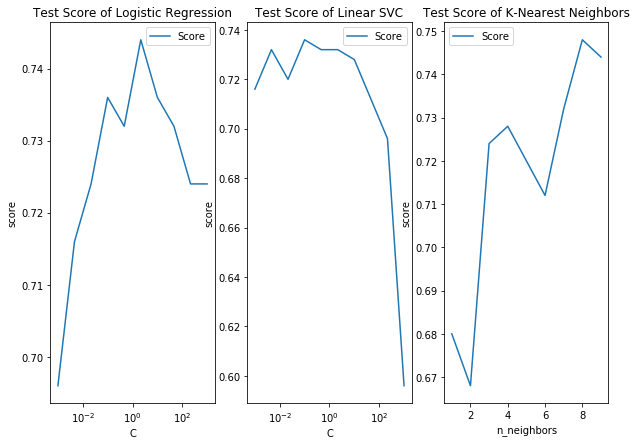

In [16]:
#Performance as function of Parameters for Logistic Regression, LinearSVC and KNN
warnings.filterwarnings('ignore')
C = np.logspace(-3,3,10)
n_neighbors = range(1,10)

LR_test_score_grid = [LogisticRegression(C=C[i]).fit(X_train,y_train).score(X_test,y_test) for i in range(len(C))]
SVC_test_score_grid = [LinearSVC(C=C[i]).fit(X_train,y_train).score(X_test,y_test) for i in range(len(C))]
KNN_test_score_grid = [KNeighborsClassifier(n_neighbors=n_neighbors[i]).fit(X_train,y_train).score(X_test,y_test) for i in range(len(n_neighbors))]

fig, ax = plt.subplots(1,3,figsize=(10,7))

ax[0].plot(C,LR_test_score_grid,label="Score")
ax[0].set_xscale("log")
ax[0].set_xlabel("C")
ax[0].set_ylabel("score")
ax[0].title.set_text("Test Score of Logistic Regression")
ax[0].legend()

ax[1].plot(C,SVC_test_score_grid,label="Score")
ax[1].set_xscale("log")
ax[1].set_xlabel("C")
ax[1].set_ylabel("score")
ax[1].title.set_text("Test Score of Linear SVC")
ax[1].legend()

ax[2].plot(n_neighbors,KNN_test_score_grid,label="Score")
ax[2].set_xlabel("n_neighbors")
ax[2].set_ylabel("score")
ax[2].title.set_text("Test Score of K-Nearest Neighbors")
ax[2].legend()



The performance graphs confirm that Logistic Regression models are the most reliable of the three classification methods, as the test scores are consistently above 70% even when the parameters change. LinearSVC tends to have worse results for large values of C. K-Nearest Neighbors results are lower in general than for the other two methods.

## 1.6 Cross Validation without Stratification and with Shuffling

In [17]:
# KFold Cross-validation with Shuffling
warnings.filterwarnings('ignore')
cv = KFold(5,shuffle=True)

pipe = Pipeline([('regressor',LogisticRegression())])

param_grid = [{'regressor': [LogisticRegression()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [LinearSVC()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [KNeighborsClassifier()],
              'regressor__n_neighbors':range(1,10)
             }]

grid = GridSearchCV(pipe, param_grid,cv=cv,)
grid.fit(X_train,y_train)

print("Best model based on training : "+ str(grid.best_params_))
print("Score of best model on test : "+str(grid.score(X_test,y_test)))


Best model based on training : {'regressor': LogisticRegression(C=0.46415888336127775, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'regressor__C': 0.46415888336127775}
Score of best model on test : 0.732


When we use shuffling and KFold, the best model on this run was LogisticRegression, but the value of the parameter found changed.

In [18]:
# KFold Cross-Validation with random seed Shuffling 
warnings.filterwarnings('ignore')
cv = KFold(5,shuffle=True,random_state=RandomState(1))

pipe = Pipeline([('regressor',LogisticRegression())])

param_grid = [{'regressor': [LogisticRegression()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [LinearSVC()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [KNeighborsClassifier()],
              'regressor__n_neighbors':range(1,10)
             }]

grid = GridSearchCV(pipe, param_grid,cv=cv,)
grid.fit(X_train,y_train)

print("Best model based on training : "+ str(grid.best_params_))
print("Score of best model on test : "+str(grid.score(X_test,y_test)))


Best model based on training : {'regressor': LinearSVC(C=0.021544346900318832, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0), 'regressor__C': 0.021544346900318832}
Score of best model on test : 0.72


Changing the Random Seed has once again changed the optimal estimator. The best estimator is now a LinearSVC model with C=0.022(results might change if you run the code again).

In [19]:
# KFold Cross-Validation with Shuffling, random seed and random state train test split
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = train_test_split(df,df_y["IsGood"],random_state=RandomState(1))

#We convert X_train and X_test from sparse matrix to array
X_train = X_train.toarray()
X_test = X_test.toarray()

cv = KFold(5,shuffle=True,random_state=RandomState(1))

pipe = Pipeline([('regressor',LogisticRegression())])

param_grid = [{'regressor': [LogisticRegression()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [LinearSVC()],
               'regressor__C':np.logspace(-3,3,10)},
              {'regressor': [KNeighborsClassifier()],
              'regressor__n_neighbors':range(1,10)
             }]

grid = GridSearchCV(pipe, param_grid,cv=cv,)
grid.fit(X_train,y_train)

print("Best model based on training : "+ str(grid.best_params_))
print("Score of best model on test : "+str(grid.score(X_test,y_test)))



Best model based on training : {'regressor': LinearSVC(C=0.021544346900318832, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0), 'regressor__C': 0.021544346900318832}
Score of best model on test : 0.76


Changing the random state of the split into training and test and repeating this process for the train/validation split did not change the value of the parameter or the estimator in this instance. The best model is still a LinearSVC model.  It is worth noting that for some runs, the best estimator is a LogisticRegression, whose parameters also change when we introduce shuffling, KFold and RandomStates.

## 1.7 Visualizing main coefficients

In [20]:
#We first select satisfactory parameters for LogisticRegression
warnings.filterwarnings('ignore')
pipe = Pipeline([('regressor',LogisticRegression())])

param_grid = [{'regressor': [LogisticRegression()],
               'regressor__C':np.logspace(-3,3,10)}]

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train,y_train)

model_LR = LogisticRegression(C = grid.best_params_["regressor__C"]).fit(X_train,y_train)

#We select satisfactory parameters for LinearSVC

pipe = Pipeline([('regressor',LinearSVC())])

param_grid = [{'regressor': [LinearSVC()],
               'regressor__C':np.logspace(-3,3,10)}]

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train,y_train)

model_SVC = LinearSVC(C = grid.best_params_["regressor__C"]).fit(X_train,y_train)

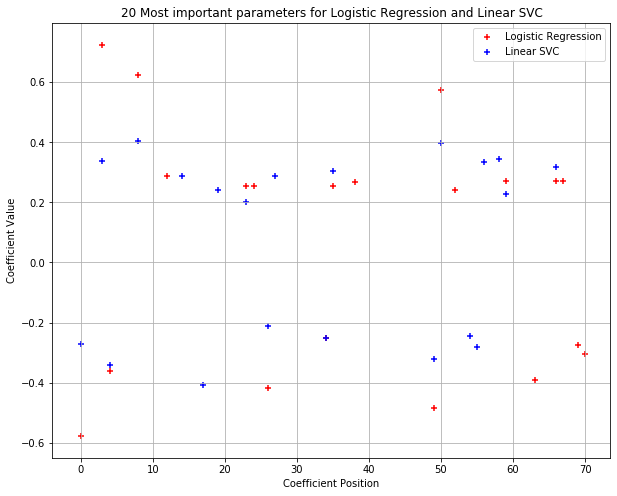

In [21]:
#We select the 20 most important coefficients (i.e those with largest absolute value) for Logistic Regression and LinearSVC
coef_LR = np.absolute(model_LR.coef_)
coef_LR = np.argsort(coef_LR) #sorts from smallest to largest
coef_LR = np.flip(coef_LR)[0][:20] #selects 20 most important coefs

coef_SVC = np.absolute(model_SVC.coef_)
coef_SVC = np.argsort(coef_SVC) 
coef_SVC = np.flip(coef_SVC)[0][:20] 

plt.figure(figsize=(10,8))
plt.scatter(coef_LR,[model_LR.coef_[0][i] for i in coef_LR],marker="+",c="r",label="Logistic Regression")
plt.scatter(coef_SVC,[model_SVC.coef_[0][i] for i in coef_SVC],marker="+",c="b",label="Linear SVC")
plt.xlabel("Coefficient Position")
plt.ylabel("Coefficient Value")
plt.title("20 Most important parameters for Logistic Regression and Linear SVC")
plt.grid()
plt.legend(loc="upper right")

In [22]:
print(np.sort(coef_LR))
print(np.sort(coef_SVC))

[ 0  3  4  8 12 23 24 26 34 35 38 49 50 52 59 63 66 67 69 70]
[ 0  3  4  8 14 17 19 23 26 27 34 35 49 50 54 55 56 58 59 66]


The 20 most important parameters for Linear Regression and for Linear SVC are almost identical (even though their magnitudes are different).